# Compare likelihoods 

Debugging the relative binning likelihood and the problem of weird peaking of the Mc likelihood values

Also see the .py script, which came first

## Preamble

### Imports and jim prior setup

In [1]:
import psutil
p = psutil.Process()
p.cpu_affinity([0])

from tqdm import tqdm
import json
import numpy as np
import os
import jax
import jax.numpy as jnp
from jimgw.prior import Uniform, Composite
import matplotlib.pyplot as plt
import pickle

from save_likelihoods import NAMING as naming 
from save_likelihoods import PRIOR

prior_ranges = jnp.array([PRIOR[name] for name in naming])
prior_low, prior_high = prior_ranges[:, 0], prior_ranges[:, 1]

N_samples = 50

In [2]:
# Priors without transformation
Mc_prior = Uniform(prior_low[0], prior_high[0], naming=['M_c'])
q_prior = Uniform(prior_low[1], prior_high[1], naming=['q'],
                    transforms={
    'q': (
        'eta',
        lambda params: params['q'] /
        (1 + params['q']) ** 2
    )
}
)
s1z_prior = Uniform(prior_low[2], prior_high[2], naming=['s1_z'])
s2z_prior = Uniform(prior_low[3], prior_high[3], naming=['s2_z'])
lambda_1_prior = Uniform(prior_low[4], prior_high[4], naming=['lambda_1'])
lambda_2_prior = Uniform(prior_low[5], prior_high[5], naming=['lambda_2'])
dL_prior = Uniform(prior_low[6], prior_high[6], naming=['d_L'])
tc_prior = Uniform(prior_low[7], prior_high[7], naming=['t_c'])
phic_prior = Uniform(prior_low[8], prior_high[8], naming=['phase_c'])
cos_iota_prior = Uniform(prior_low[9], prior_high[9], naming=["cos_iota"],
                            transforms={
    "cos_iota": (
        "iota",
        lambda params: jnp.arccos(
            jnp.arcsin(
                jnp.sin(params["cos_iota"] / 2 * jnp.pi)) * 2 / jnp.pi
        ),
    )
},
)
psi_prior = Uniform(prior_low[10], prior_high[10], naming=["psi"])
ra_prior = Uniform(prior_low[11], prior_high[11], naming=["ra"])
sin_dec_prior = Uniform(prior_low[12], prior_high[12], naming=["sin_dec"],
                        transforms={
    "sin_dec": (
        "dec",
        lambda params: jnp.arcsin(
            jnp.arcsin(
                jnp.sin(params["sin_dec"] / 2 * jnp.pi)) * 2 / jnp.pi
        ),
    )
},
)

# Compose the prior
prior_list = [
    Mc_prior,
    q_prior,
    s1z_prior,
    s2z_prior,
    lambda_1_prior,
    lambda_2_prior,
    dL_prior,
    tc_prior,
    phic_prior,
    cos_iota_prior, # 9
    psi_prior, # 10
    ra_prior, # 11
    sin_dec_prior, # 12
]
complete_prior = Composite(prior_list)
bounds = jnp.array([[p.xmin, p.xmax] for p in complete_prior.priors])
print("Finished prior setup")

Finished prior setup


In [3]:
jim_path = './outdir/injection_14/likelihood.pkl'
bilby_path = "/home/narola.bharatbhai/jim_bilby_crosscheck/jim/bilby_runs/injection_14/update_theta_jn_injection_14_result.json" # on CIT!

### Load jim data

In [4]:
# Load config.json
with open(f'./outdir/injection_14/config.json', 'r') as f:
    config = json.load(f)
    
true_params_np = np.array([config[p] for p in naming])
true_mc = true_params_np[0]

# Convert cos_iota to iota, sin_dec to dec
true_params_np[9] = jnp.arccos(true_params_np[9])
true_params_np[12] = jnp.arcsin(true_params_np[12])

# Load jim chains

jim_data = np.load(f'./outdir/injection_14/results_production.npz')
jim_chains, jim_log_prob = jim_data["chains"], jim_data["log_prob"]

jim_chains = np.array(jim_chains)
jim_chains = np.reshape(jim_chains, (-1, 13))

jim_log_prob = np.reshape(jim_log_prob, (-1,))

# Thin the samples a bit
jump = 100
jim_chains = jim_chains[::jump]
jim_log_prob = jim_log_prob[::jump]

In [5]:
# Load likelihood with pickle
with open(jim_path, 'rb') as f:
    my_likelihood = pickle.load(f)

### Load bilby data

In [6]:
# Load the bilby data 
print("Loading bilby data")
with open(bilby_path, "r") as f:
    bilby_data = json.load(f)
bilby_posterior = bilby_data["posterior"]["content"]

bilby_naming = ['chirp_mass',
          'mass_ratio',
          'chi_1',
          'chi_2',
          'lambda_1',
          'lambda_2',
          'luminosity_distance',
          'geocent_time',
          'phase',
          'theta_jn',
          'psi',
          'ra',
          'dec'] # note we also have: # 'log_likelihood', 'log_prior'

bilby_chains = np.array([bilby_posterior[name] for name in bilby_naming])
bilby_chains = bilby_chains.T

print(np.shape(bilby_chains))

Loading bilby data
(12189, 13)


## Comparing bilby output to jim likelihood

### jim likelihood

In [7]:
prior_params = complete_prior.add_name(jim_chains.T)
jim_prior_prob = complete_prior.log_prob(prior_params)

print("np.mean(jim_prior_prob)")
print(np.mean(jim_prior_prob))

jim_log_likelihood = jim_log_prob - jim_prior_prob

print(np.shape(jim_log_likelihood))

mc_jim = jim_chains[:, 0]

np.mean(jim_prior_prob)
-22.479974306343404
(7500,)


### bilby likelihood

In [8]:
bilby_log_likelihood = np.array(bilby_posterior['log_likelihood'])
bilby_log_prior = np.array(bilby_posterior['log_prior'])
log_prob = bilby_log_likelihood + bilby_log_prior

### Comparison

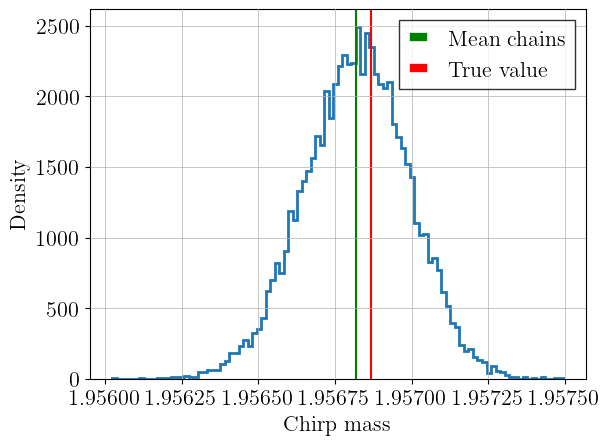

In [9]:
np.shape(bilby_chains)
mc_bilby = bilby_chains[:, 0]
plt.hist(mc_bilby, bins=100, histtype='step', density=True, linewidth=2)
plt.axvline(np.mean(mc_bilby), color='green', label = 'Mean chains')
plt.axvline(true_mc, color='red', label = 'True value')
plt.legend()
plt.xlabel('Chirp mass')
plt.ylabel('Density')
plt.show()

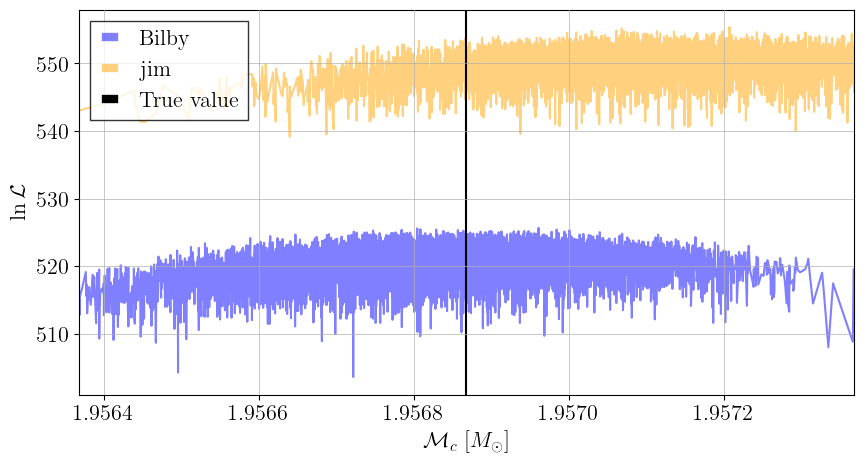

In [10]:
alpha = 0.5
# Argsort the the Mc and sort likelihood as well there
argsort = np.argsort(mc_bilby)
mc_bilby_sorted = mc_bilby[argsort]
bilby_log_likelihood_sorted = bilby_log_likelihood[argsort]

argsort = np.argsort(mc_jim)
mc_jim_sorted = mc_jim[argsort]
jim_log_likelihood_sorted = jim_log_likelihood[argsort]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(mc_bilby_sorted, bilby_log_likelihood_sorted, color = "blue", label = "Bilby", alpha = alpha)
plt.plot(mc_jim_sorted, jim_log_likelihood_sorted, color = "orange", label = "jim", alpha = alpha)
plt.axvline(true_mc, color='black', label = 'True value')
# Limit
mc_std = 0.0005
mc_left = true_mc - mc_std
mc_right = true_mc + mc_std
plt.xlim(mc_left, mc_right)
plt.xlabel(r'$\mathcal{M}_c \ [M_\odot]$')
plt.ylabel(r'$\ln \mathcal{L}$')
plt.legend()
plt.show()

In [11]:
# # Evaluate the likelihood object also separately at the true parameters
# N_samples = 50
# mc_values = np.linspace(mc_left, mc_right, N_samples)

# my_params = np.vstack(N_samples * [true_params_np])
# print(np.shape(my_params))

# my_params[:, 0] = mc_values
# my_params = jnp.array(my_params)

# my_params_stacked = jnp.array(my_params).T
# my_params_stacked_named = complete_prior.add_name(my_params_stacked)

# # Convert cos_iota to iota, sin_dec to dec, and q to eta
# my_params_stacked_named["iota"] = jnp.arccos(my_params_stacked_named["cos_iota"])
# my_params_stacked_named["dec"] = jnp.arcsin(my_params_stacked_named["sin_dec"])
# q = my_params_stacked_named["q"]
# my_params_stacked_named["eta"] = q / (1 + q)**2

# likelihood_evaluate_vmap = jax.vmap(my_likelihood.evaluate, in_axes=(0, None))
# likelihood_evaluate_original_vmap = jax.vmap(my_likelihood.evaluate_original, in_axes=(0, None))

# my_log_likelihoods = likelihood_evaluate_vmap(my_params_stacked_named, {})

In [17]:
true_params_np

array([ 1.95686776e+00,  8.77416200e-01,  9.73511040e-03,
        4.89805909e-02,  1.06468360e+03,  3.72372209e+03,
        1.26182182e+02, -2.36038967e-02,  3.23858522e+00,
        2.64086195e+00,  5.16157902e-01,  5.97810112e+00,
       -1.94474493e-02])

In [16]:
# Evaluate the likelihood object also separately at the true parameters
N_samples = 50
mc_values = np.linspace(mc_left, mc_right, N_samples)

my_params = np.vstack(N_samples * [true_params_np])
print(np.shape(my_params))

my_params[:, 0] = mc_values
my_params = jnp.array(my_params)

### Evaluate the likelihood at these:
my_log_likelihoods = []
for param in tqdm(my_params):
    my_params_named = complete_prior.add_name(param)

    # Convert cos_iota to iota, sin_dec to dec, q to eta
    my_params_named["iota"] = jnp.arccos(my_params_named["cos_iota"])
    my_params_named["dec"] = jnp.arcsin(my_params_named["sin_dec"])
    q = my_params_named["q"]
    my_params_named["eta"] = q / (1 + q) ** 2
    value = my_likelihood.evaluate_original(my_params_named, {})
    print(value)
    my_log_likelihoods.append(value)

my_log_likelihood = np.array(my_log_likelihoods)
print(np.shape(my_log_likelihood))

(50, 13)


  4%|▍         | 2/50 [00:01<00:33,  1.44it/s]

nan
nan


  8%|▊         | 4/50 [00:01<00:15,  3.03it/s]

nan
nan


 10%|█         | 5/50 [00:02<00:12,  3.64it/s]

nan


 14%|█▍        | 7/50 [00:02<00:10,  4.04it/s]

nan
nan


 18%|█▊        | 9/50 [00:02<00:07,  5.24it/s]

nan
nan


 22%|██▏       | 11/50 [00:03<00:06,  5.81it/s]

nan
nan


 26%|██▌       | 13/50 [00:03<00:05,  6.22it/s]

nan
nan


 30%|███       | 15/50 [00:03<00:05,  6.40it/s]

nan
nan


 34%|███▍      | 17/50 [00:04<00:04,  6.89it/s]

nan
nan


 38%|███▊      | 19/50 [00:04<00:04,  6.36it/s]

nan
nan


 42%|████▏     | 21/50 [00:04<00:04,  6.47it/s]

nan
nan


 46%|████▌     | 23/50 [00:04<00:03,  6.77it/s]

nan
nan


 50%|█████     | 25/50 [00:05<00:03,  6.29it/s]

nan
nan


 54%|█████▍    | 27/50 [00:05<00:03,  6.44it/s]

nan
nan


 58%|█████▊    | 29/50 [00:05<00:03,  6.75it/s]

nan
nan


 62%|██████▏   | 31/50 [00:06<00:03,  6.16it/s]

nan
nan


 66%|██████▌   | 33/50 [00:06<00:02,  6.35it/s]

nan
nan


 70%|███████   | 35/50 [00:06<00:02,  7.02it/s]

nan
nan


 74%|███████▍  | 37/50 [00:07<00:01,  7.03it/s]

nan
nan


 78%|███████▊  | 39/50 [00:07<00:01,  6.35it/s]

nan
nan


 82%|████████▏ | 41/50 [00:07<00:01,  6.88it/s]

nan
nan


 86%|████████▌ | 43/50 [00:08<00:01,  6.85it/s]

nan
nan


 90%|█████████ | 45/50 [00:08<00:00,  6.29it/s]

nan
nan


 94%|█████████▍| 47/50 [00:08<00:00,  6.82it/s]

nan
nan


 98%|█████████▊| 49/50 [00:08<00:00,  6.85it/s]

nan
nan


100%|██████████| 50/50 [00:09<00:00,  5.51it/s]

nan
(50,)


In [13]:
my_log_likelihoods

[Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64),
 Array(nan, dtype=fl

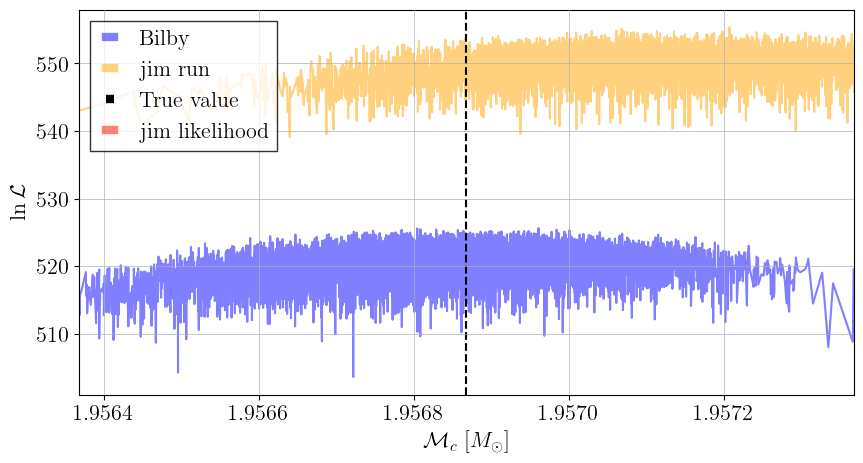

In [14]:
alpha = 0.5
# Argsort the the Mc and sort likelihood as well there
argsort = np.argsort(mc_bilby)
mc_bilby_sorted = mc_bilby[argsort]
bilby_log_likelihood_sorted = bilby_log_likelihood[argsort]

argsort = np.argsort(mc_jim)
mc_jim_sorted = mc_jim[argsort]
jim_log_likelihood_sorted = jim_log_likelihood[argsort]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(mc_bilby_sorted, bilby_log_likelihood_sorted, color = "blue", label = "Bilby", alpha = alpha)
plt.plot(mc_jim_sorted, jim_log_likelihood_sorted, color = "orange", label = "jim run", alpha = alpha)
plt.axvline(true_mc, color='black', linestyle = "--", label = 'True value')
plt.plot(mc_values, my_log_likelihoods, color = "red", label = "jim likelihood", alpha = alpha)
# Limit
mc_std = 0.0005
mc_left = true_mc - mc_std
plt.xlim(true_mc - mc_std, true_mc + mc_std)
plt.xlabel(r'$\mathcal{M}_c \ [M_\odot]$')
plt.ylabel(r'$\ln \mathcal{L}$')
plt.legend()
plt.show()

In [15]:
my_log_likelihood

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan])